In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import math
import keras
from random import shuffle
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [22]:
# Import data cell
#  - Creates two dataframes, one for test data and one for training data. 
#  - Add labels two both datasets 
#  - Time countinuos

gear2Path = os.path.normpath('gear2')
gear3Path = os.path.normpath('gear3')
gear4Path = os.path.normpath('gear4')
doublePath = os.path.normpath('double')
pathList = [gear2Path,gear3Path,gear4Path,doublePath]
classDict = {'Gear2':0,'Gear3':1,'Gear4':2,'Double':3}
classDict_Lower = {'gear2':0,'gear3':1,'gear4':2,'double':3}
dataList = []
dataListRolling = []
label = pd.DataFrame()

for p in pathList:
    pPath = os.path.normpath('/Users/mariekorneliusson/documents/AiSports/skate_city') + '/' + p
    d = pd.read_csv(pPath + '.csv',low_memory = False)
    label = pd.DataFrame({'label': classDict_Lower[p]*np.ones(len(d),)})
    rolling= d.rolling(window=3,min_periods=1)
    rolling_pd = rolling.mean()
    rolling_pd  = rolling_pd.join(label)
    d = d.join(label)
    dataList.append(d)
    dataListRolling.append(rolling_pd)

In [23]:
X = pd.concat(dataListRolling)

data = pd.DataFrame(X)
delta_t = 0.02
data.reset_index(inplace = True, drop = True)
for i in range(len(data)):
    data.loc[i,'t'] = i*delta_t

In [24]:
def strikesData(data,epsilon,delta_t):
    # Data - dataframe
    # to find the strikes
    time_column = 0
    nbrSamples = data.shape[0]
    feautres = data.shape[1]
    strike_list = []
    #ind = data.loc[(data['fL'] >= epsilon) & (data['fR'] >= epsilon)].values
    ind = data.loc[(data['fL'] >= epsilon)].values
    data_array = data.values
    first_index = 0
    for i in range(ind.shape[0]-1):
        if ind[i+1,time_column] - ind[i,time_column] > 2*delta_t:
            last_time = ind[i,time_column]
            last_index = np.where(data_array[:,time_column]==last_time)[0][0]
            strike = data_array[first_index:last_index,:]
            strike_list.append(strike)
            first_index = last_index + 1
    
    return strike_list

In [28]:
strike_list = strikesData(data,0.4,delta_t)

In [29]:
print(len(strike_list))

894


In [30]:
max_length = 0 
for i in range(len(strike_list)):
    if max_length < strike_list[i].shape[0]:
        max_length = strike_list[i].shape[0]
print(max_length)

3529


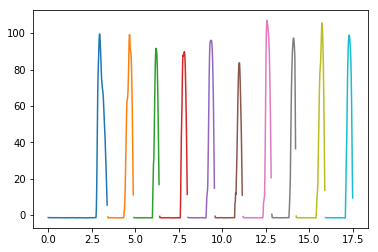

In [31]:
for i in range(10):
    plt.plot(strike_list[i][:,0],strike_list[i][:,1])

In [32]:
def reshape_and_pad_max(strike_list,nbr_of_classes,pad,max_length):
    nbr_of_strikes = 0
    ###### If some has zeros length ######
    for i in range(len(strike_list)):
        if strike_list[i].shape[0] > 0 :
            if strike_list[i].shape[0] < max_length :
                nbr_of_strikes = nbr_of_strikes + 1
            
    dimX = strike_list[0].shape[1]
    time_step = max_length
    #strike_data = (-1)*np.ones((nbr_of_strikes,time_step,dimX))
    strike_data = np.zeros((nbr_of_strikes,time_step,dimX)) - pad
    labels = np.zeros((nbr_of_strikes,nbr_of_classes))
    k = 0 
    for i in range(len(strike_list)):
        strike = strike_list[i]
        if strike_list[i].shape[0] > 0 :
            if strike_list[i].shape[0] < max_length :
                for j in range(strike.shape[0]):
                    strike_data[k,j,:] = strike[j,:]

                labels[k,int(strike[0,dimX-1])] = 1
                k = k + 1

    return strike_data,labels,time_step

In [33]:
nbr_of_classes = 4
pad = 0
max_length = 140
[X,Y,time_step] = reshape_and_pad_max(strike_list,nbr_of_classes,pad,max_length)

In [34]:
print(X.shape)
print(Y.shape)

(854, 140, 22)
(854, 4)


(171,)
(215,)
(130,)
(338,)


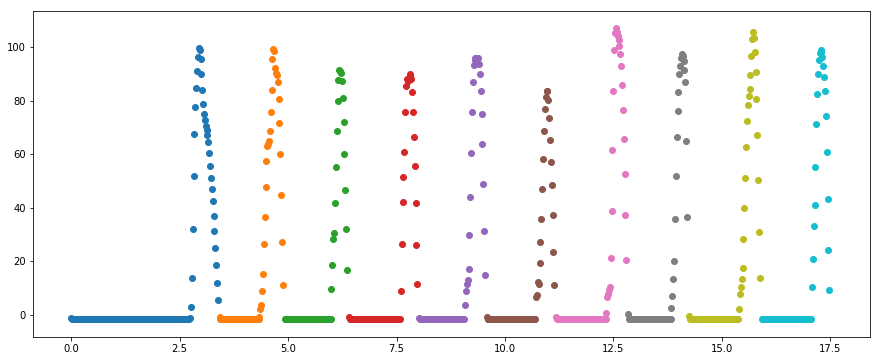

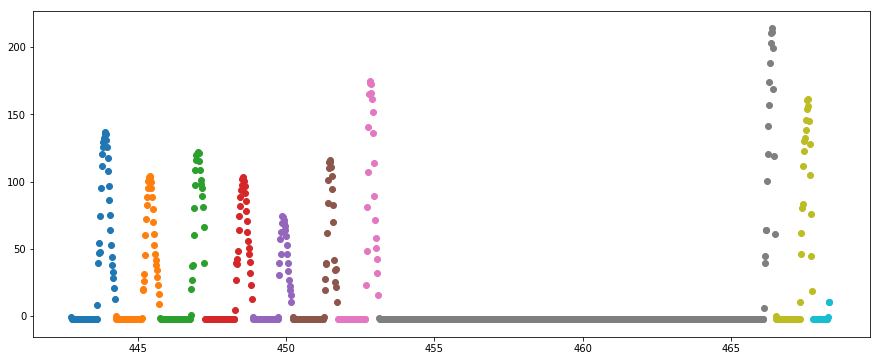

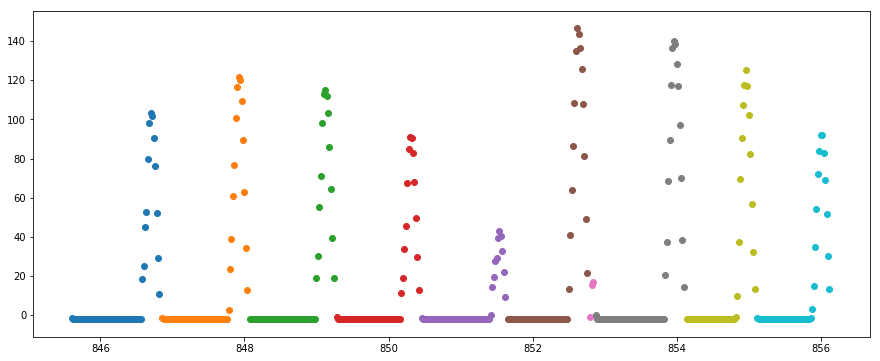

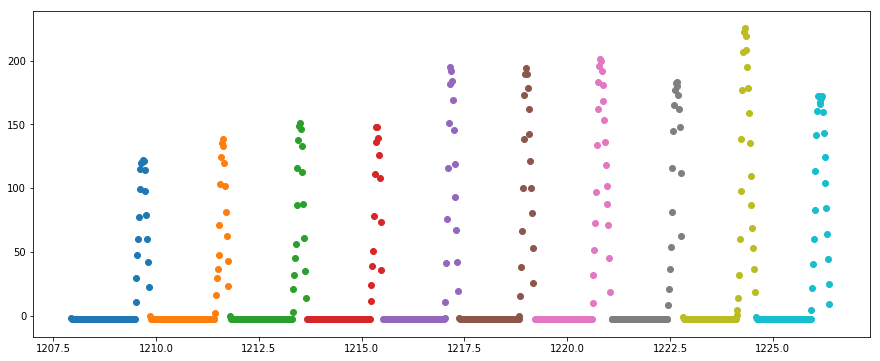

In [37]:
gear_ind_list = []
for c in range(4):
    g = np.where(Y[:,c] == 1)[0].ravel()
    gear_ind_list.append(g)
    print(np.where(Y[:,c] == 1)[0].ravel().shape)
    if g.shape[0] > 10:
        plt.figure(c,figsize=(15,6))
        for i in range(10):
            strike_t = strike_list[g[i]][:,0]
            strike_f = strike_list[g[i]][:,1]
            plt.scatter(strike_t,strike_f)

In [36]:
np.save('X_Third_Skier_New',X)
np.save('Y_Third_Skier_New', Y)

In [17]:
key_list = data.keys().tolist()

In [20]:
print(key_list)

['t', 'fL', 'thL', 'w1L', 'w2L', 'w3L', 'a1L', 'a2L', 'a3L', 'fR', 'thR', 'w1R', 'w2R', 'w3R', 'a1R', 'a2R', 'a3R', 'x', 'y', 'z', 'v', 'label']
